(moderation_analysis)=
# Bayesian moderation analysis

:::{post} May, 2024
:tags: moderation, path analysis, causal inference
:category: beginner
:author: Benjamin T. Vincent
:::

This notebook covers Bayesian [moderation analysis](https://en.wikipedia.org/wiki/Moderation_(statistics)). This is appropriate when we believe that one predictor variable (the moderator) may influence the linear relationship between another predictor variable and an outcome. Here we look at an example where we look at the relationship between hours of training and muscle mass, where it may be that age (the moderating variable) affects this relationship.

This is not intended as a one-stop solution to a wide variety of data analysis problems, rather, it is intended as an educational exposition to show how moderation analysis works and how to conduct Bayesian parameter estimation in PyMC.

Moderation analysis has been approached from a variety of approaches:
* Statistical approaches: It is entirely possible to approach moderation analysis from a purely statistical perspective. In this approach we might build a linear model (for example) whose aim is purely to _describe_ the data we have while making no claims about causality.
* Path analysis: This approach asserts that the variables in the model are causally related and is exemplified in {cite:t}`hayes2017introduction`, for example. This approach cannot be considered as 'fully causal' as it lacks a variety of the concepts present in the causal approach.
* Causal inference: This approach builds upon the path analysis approach in that there is a claim of causal relationships between the variables. But it goes further in that there are additional causal concepts which can be brought to bear.

:::{attention}
Note that this is sometimes mixed up with [mediation analysis](https://en.wikipedia.org/wiki/Mediation_(statistics)). Mediation analysis is appropriate when we believe the effect of a predictor variable upon an outcome variable is (partially, or fully) mediated through a 3rd mediating variable. Readers are referred to the textbook by {cite:t}`hayes2017introduction` as a comprehensive (albeit Frequentist) guide to moderation and related models as well as the PyMC example {ref}`mediation_analysis`.
:::

In [1]:
import arviz as az
import daft
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import xarray as xr

from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

In [2]:
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = 'retina'

First in the (hidden) code cell below, we define some helper functions for plotting that we will use later.

In [3]:
def make_scalarMap(m):
    """Create a Matplotlib `ScalarMappable` so we can use a consistent colormap across both data points and posterior predictive lines. We can use `scalarMap.cmap` to use as a colormap, and `scalarMap.to_rgba(moderator_value)` to grab a colour for a given moderator value."""
    return ScalarMappable(norm=Normalize(vmin=np.min(m), vmax=np.max(m)), cmap="viridis")


def plot_data(x, moderator, y, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    else:
        fig = plt.gcf()

    h = ax.scatter(x, y, c=moderator, cmap=scalarMap.cmap)
    ax.set(xlabel="x", ylabel="y")
    # colourbar for moderator
    cbar = fig.colorbar(h)
    cbar.ax.set_ylabel("moderator")
    return ax


def posterior_prediction_plot(result, x, moderator, m_quantiles, ax=None):
    """Plot posterior predicted `y`"""
    if ax is None:
        fig, ax = plt.subplots(1, 1)

    post = az.extract(result)
    xi = xr.DataArray(np.linspace(np.min(x), np.max(x), 20), dims=["x_plot"])
    m_levels = result.constant_data["m"].quantile(m_quantiles).rename({"quantile": "m_level"})

    for p, m in zip(m_quantiles, m_levels):
        y = post.β0 + post.β1 * xi + post.β2 * xi * m + post.β3 * m
        region = y.quantile([0.025, 0.5, 0.975], dim="sample")
        ax.fill_between(
            xi,
            region.sel(quantile=0.025),
            region.sel(quantile=0.975),
            alpha=0.2,
            color=scalarMap.to_rgba(m),
            edgecolor="w",
        )
        ax.plot(
            xi,
            region.sel(quantile=0.5),
            color=scalarMap.to_rgba(m),
            linewidth=2,
            label=f"{p*100}th percentile of moderator",
        )

    ax.legend(fontsize=9)
    ax.set(xlabel="x", ylabel="y")
    return ax


def plot_moderation_effect(result, m, m_quantiles, ax=None):
    """Spotlight graph"""

    if ax is None:
        fig, ax = plt.subplots(1, 1)

    post = az.extract(result)

    # calculate 95% CI region and median
    xi = xr.DataArray(np.linspace(np.min(m), np.max(m), 20), dims=["x_plot"])
    rate = post.β1 + post.β2 * xi
    region = rate.quantile([0.025, 0.5, 0.975], dim="sample")

    ax.fill_between(
        xi,
        region.sel(quantile=0.025),
        region.sel(quantile=0.975),
        alpha=0.2,
        color="k",
        edgecolor="w",
    )

    ax.plot(xi, region.sel(quantile=0.5), color="k", linewidth=2)

    # plot points at each percentile of m
    percentile_list = np.array(m_quantiles) * 100
    m_levels = np.percentile(m, percentile_list)
    for p, m in zip(percentile_list, m_levels):
        ax.plot(
            m,
            np.mean(post.β1) + np.mean(post.β2) * m,
            "o",
            c=scalarMap.to_rgba(m),
            markersize=10,
            label=f"{p}th percentile of moderator",
        )

    ax.legend(fontsize=9)

    ax.set(
        title="Spotlight graph",
        xlabel="$moderator$",
        ylabel=r"$\beta_1 + \beta_2 \cdot moderator$",
    )

## Does the effect of training upon muscularity decrease with age?

I've taken inspiration from a blog post {cite:t}`vandenbergSPSS` which examines whether age influences (moderates) the effect of training on muscle percentage. We might speculate that more training results in higher muscle mass, at least for younger people. But it might be the case that the relationship between training and muscle mass changes with age - perhaps training is less effective at increasing muscle mass in older age?

Let's see how we can visualize this in 3 different ways.

### Statistical diagram

In this approach we might model the outcome variable (muscle mass) as a function of the predictor variables. In this case they would be age, training, and the interaction term between age and training. This is a purely statistical approach and does not make any claims about causality or the direction of the relationships.

/Users/benjamv/opt/mambaforge/envs/pymc_env/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  func(*args, **kwargs)
/Users/benjamv/opt/mambaforge/envs/pymc_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


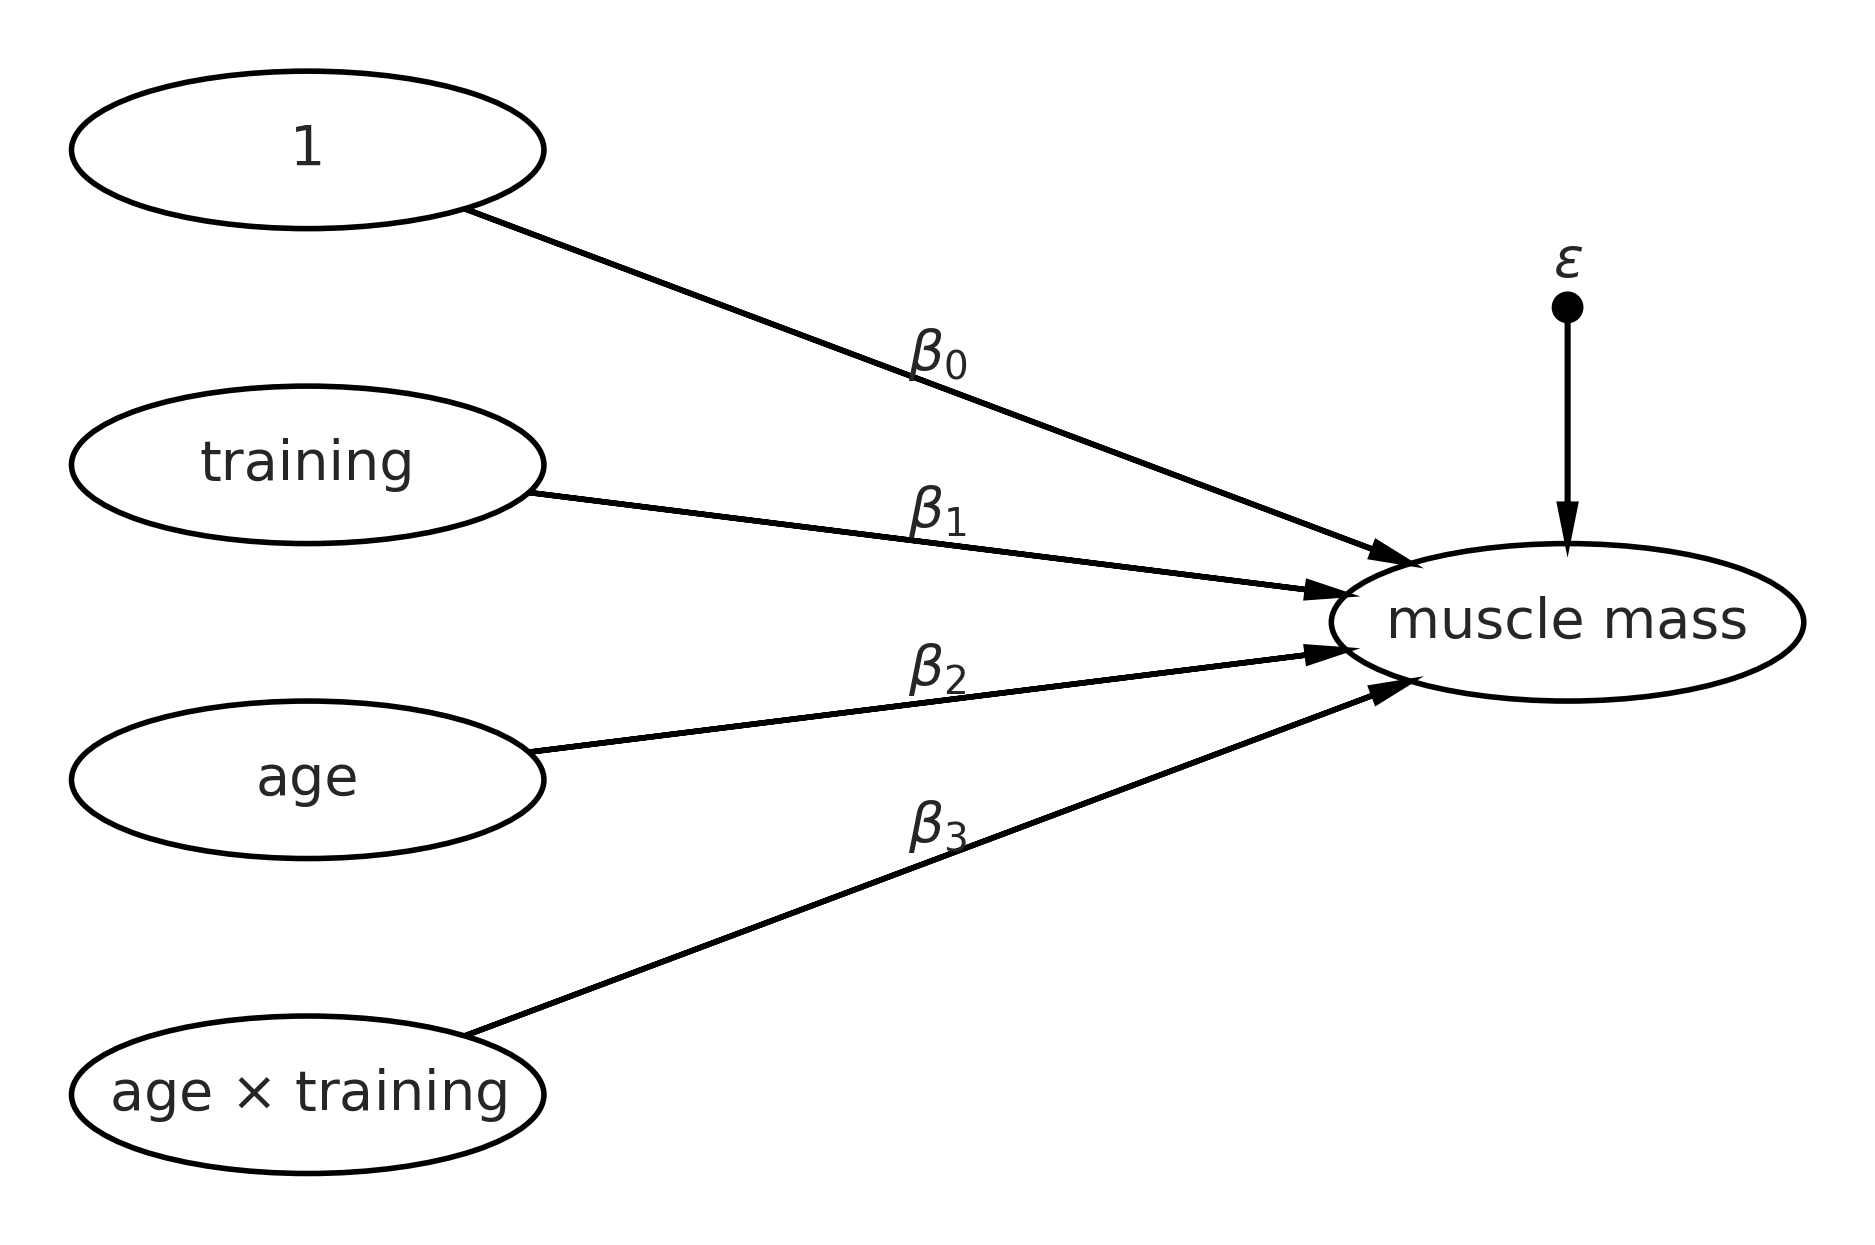

In [4]:
pgm = daft.PGM(dpi=200)

pgm.add_node("i", "1", 0, 2, aspect=3)
pgm.add_node("t", "training", 0, 1, aspect=3)
pgm.add_node("a", "age", 0, 0, aspect=3)
pgm.add_node("m", r"age $\times$ training", 0, -1, aspect=3)
pgm.add_node("y", "muscle mass", 4, 0.5, aspect=3)
pgm.add_node("e", r"$\epsilon$", 4, 1.5, fixed=True)

pgm.add_edge("i", "y", label=r"$\beta_0$")
pgm.add_edge("t", "y", label=r"$\beta_1$")
pgm.add_edge("a", "y", label=r"$\beta_2$")
pgm.add_edge("m", "y", label=r"$\beta_3$")
pgm.add_edge("e", "y")


pgm.render();

This diagram makes it explicit that the moderation effect is the interaction term between age and training. We'll come back to why this is the case below.

We could also write this in the form of an equation:

$$
\text{muscle mass} = \beta_0 + \beta_1 \times \text{training} + \beta_2 \times \text{age} + \beta_3 \times \text{training} \times \text{age} + \epsilon.
$$

### Conceptual or path diagram
We can also draw moderation in a mode conceptual manner. This is perhaps visually simpler and easier to parse, but is less explicit. The moderation is shown by an arrow from the moderating variable to the line between a predictor and an outcome variable.

But the diagram would represent the exact same equation as shown above.

![](moderation_figure.png)

### Causal diagram

Finally, we could draw the same diagram from the perspective of _structural causal modeling_. This notation shows that both age and training causally influence muscle mass. There is no specific visual notation to represent moderation in this approach. Instead, that would be captured by the functional form of the relationship $f$.

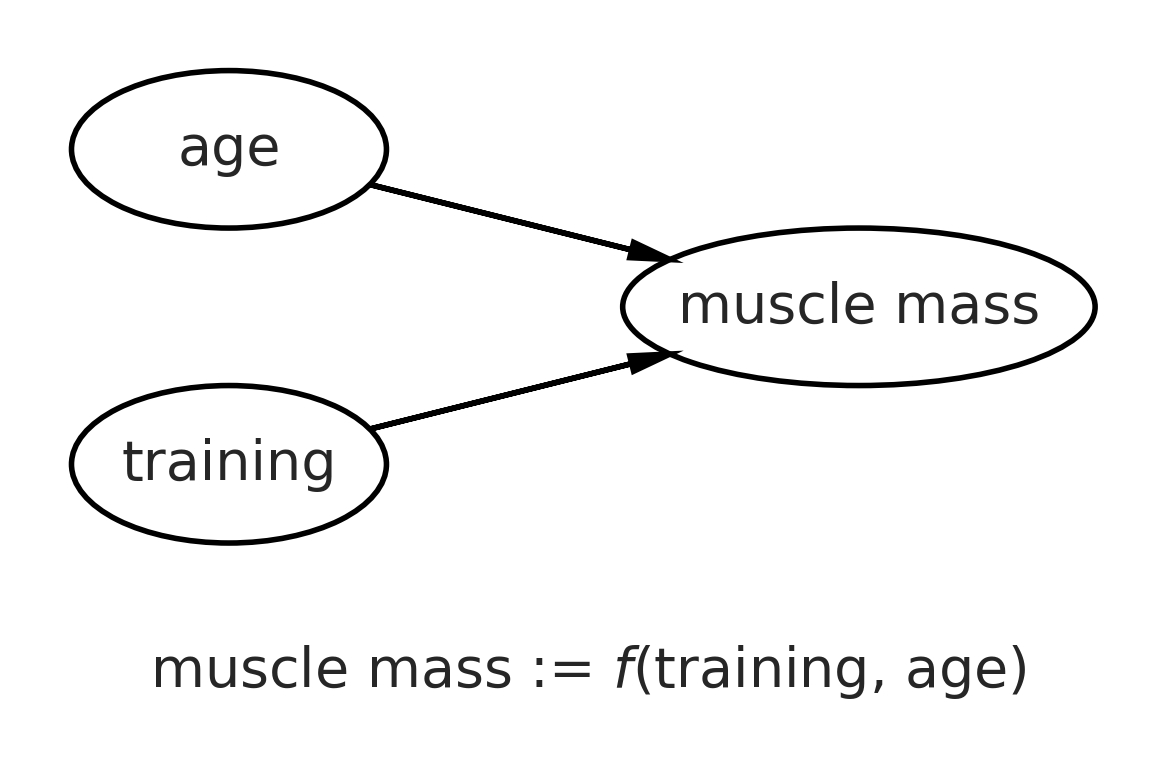

In [5]:
pgm = daft.PGM(dpi=200)

pgm.add_node("x", "training", 0, 0, aspect=2)
pgm.add_node("m", "age", 0, 1, aspect=2)
pgm.add_node("y", "muscle mass", 2, 0.5, aspect=3)

pgm.add_edge("x", "y")
pgm.add_edge("m", "y")

pgm.add_text(-0.25, -0.75, r"muscle mass := $f$(training, age)")

pgm.render();

Note that the operator $:=$ is similar to the traditional $=$ operator, but it is used to denote a _causal_ or directional relationship rather than just equality.

And we could, if we wanted to assume linearity, model this just as above:
$$
\text{muscle mass} := \beta_0 + \beta_1 \times \text{training} + \beta_2 \times \text{age} + \beta_3 \times \text{training} \times \text{age} + \epsilon.
$$

## The moderation model

Because we want to focus on the moderation concept and not the specific example it can be useful to use consistent and more abstract notation, so we will define:
- $x$ as the main predictor variable. In this example it is training.
- $y$ as the outcome variable. In this example it is muscle percentage.
- $m$ as the moderator. In this example it is age.

### Why is the interaction term the moderation effect?
We can see that the mean $y$ is simply a multiple linear regression with an interaction term between the two predictors, $x$ and $m$. 

We can get some insight into why this is the case by thinking about this as a multiple linear regression with $x$ and $m$ as predictor variables, but where the value of $m$ influences the relationship between $x$ and $y$. This is achieved by making the regression coefficient for $x$ is a function of $m$:

$$
y \sim \beta_0 + f(m) \cdot x + \beta_3 \cdot m
$$

and if we define that as a linear function, $f(m) = \beta_1 + \beta_2 \cdot m$, we get

$$
y \sim \beta_0 + (\beta_1 + \beta_2 \cdot m) \cdot x + \beta_3 \cdot m
$$

which multiplies out to

$$
y \sim \beta_0 + \beta_1 \cdot x + \beta_2 \cdot x \cdot m + \beta_3 \cdot m
$$

:::{note}
We can use $f(m) = \beta_1 + \beta_2 \cdot m$ later to visualise the moderation effect.
:::

### Specifying a Bayesian moderation model

Ok, so let's start to define our moderation model in a Bayesian manner. For this example we will treat the outcome variable as normally distributed around the mean.

$$
\begin{aligned}
\beta_0, \ldots, \beta_3 & \sim \text{Normal}(0, 10)\\
\sigma & \sim \text{HalfCauchy}(1)\\
\mu &\sim \beta_0 + \beta_1 \cdot x + \beta_2 \cdot x \cdot m + \beta_3 \cdot m\\
y   &\sim \mathrm{Normal}(\mu, \sigma^2)
\end{aligned}
$$

where $y$, $x$, and $m$ are your observed data, $\mu$ is the expected outcome value, and the following are the model parameters for which we place priors upon:
- $\beta_0$ is the intercept, its value does not have that much importance in the interpretation of this model.
- $\beta_1$ is the rate at which $y$ (muscle percentage) increases per unit of $x$ (training hours). 
- $\beta_2$ is the coefficient for the interaction term $x \cdot m$.
- $\beta_3$ is the rate at which $y$ (muscle percentage) increases per unit of $m$ (age). 
- $\sigma$ is the standard deviation of the observation noise.



## Import data
First, we will load up our example data and do some basic data visualisation. The dataset is taken from {cite:t}`vandenbergSPSS` but it is unclear if this corresponds to real life research data or if it was simulated.

In [6]:
def load_data():
    try:
        df = pd.read_csv("../data/muscle-percent-males-interaction.csv")
    except:
        df = pd.read_csv(pm.get_data("muscle-percent-males-interaction.csv"))

    x = df["thours"].values
    m = df["age"].values
    y = df["mperc"].values
    return (x, y, m)


x, y, m = load_data()

# Make a scalar color map for this dataset (Just for plotting, nothing to do with inference)
scalarMap = make_scalarMap(m)

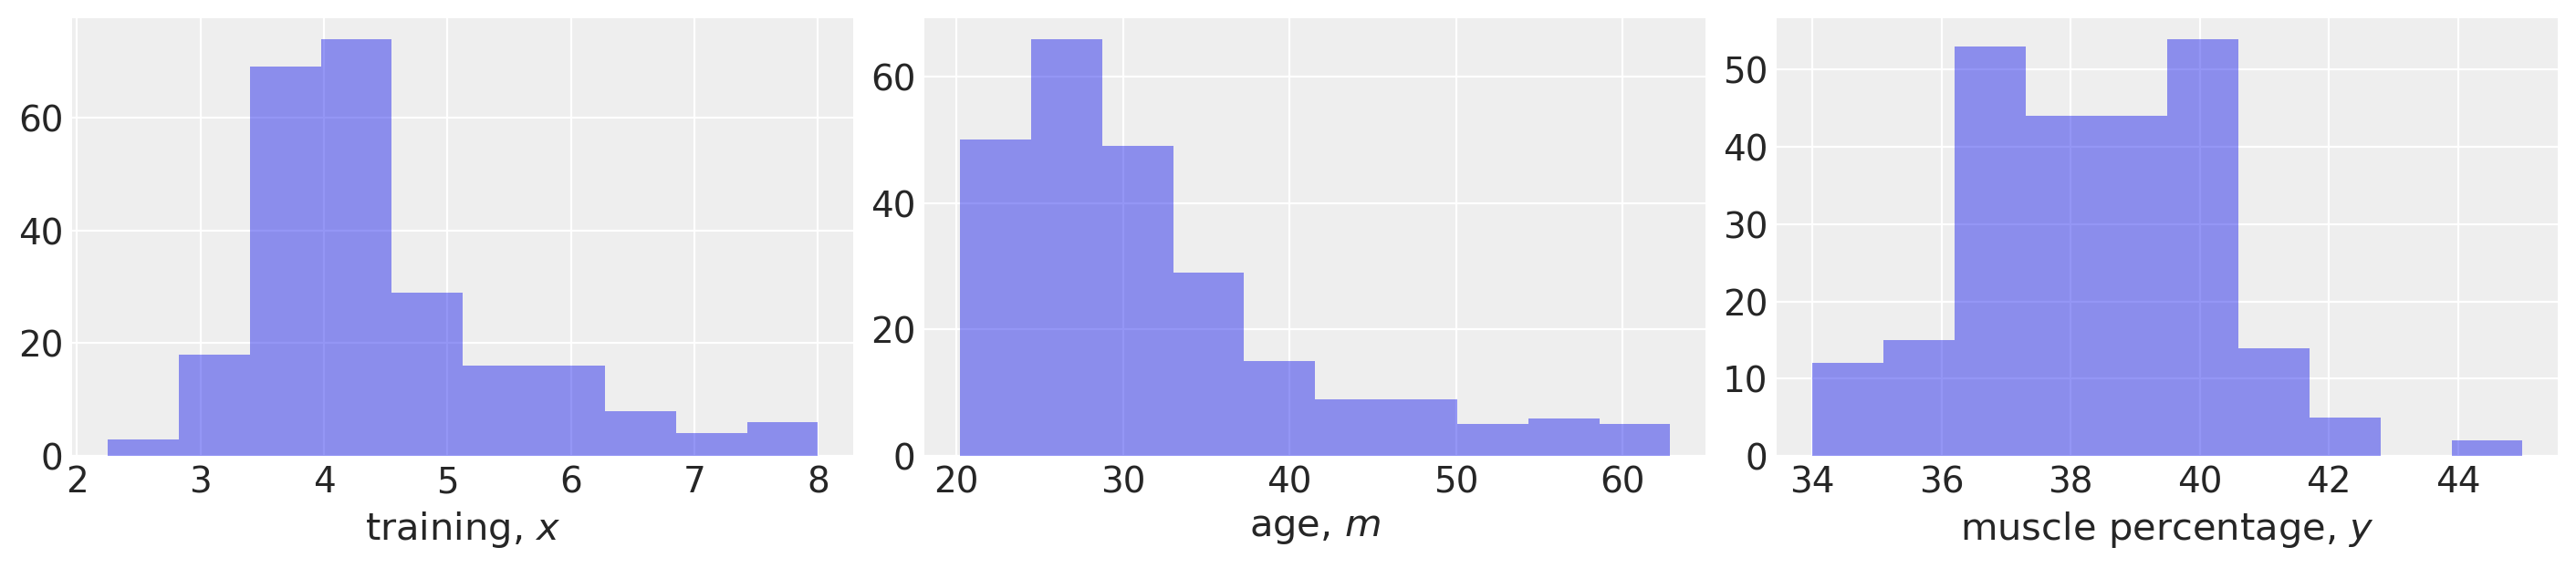

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(14, 3))

ax[0].hist(x, alpha=0.5)
ax[0].set(xlabel="training, $x$")

ax[1].hist(m, alpha=0.5)
ax[1].set(xlabel="age, $m$")

ax[2].hist(y, alpha=0.5)
ax[2].set(xlabel="muscle percentage, $y$");

## Define the PyMC model and conduct inference

In [8]:
def model_factory(x, m, y):
    with pm.Model() as model:
        x = pm.Data("x", x)
        m = pm.Data("m", m)
        # priors
        β0 = pm.Normal("β0", mu=0, sigma=10)
        β1 = pm.Normal("β1", mu=0, sigma=10)
        β2 = pm.Normal("β2", mu=0, sigma=10)
        β3 = pm.Normal("β3", mu=0, sigma=10)
        σ = pm.HalfCauchy("σ", 1)
        # likelihood
        y = pm.Normal("y", mu=β0 + (β1 * x) + (β2 * x * m) + (β3 * m), sigma=σ, observed=y)

    return model

In [9]:
model = model_factory(x, m, y)

Plot the model graph to confirm it is as intended.

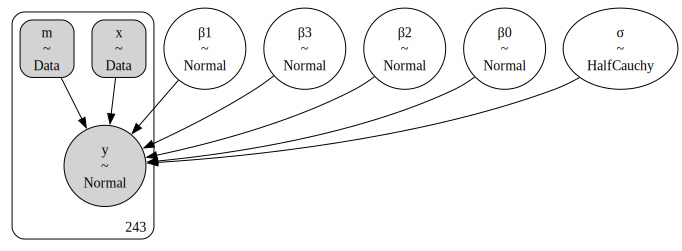

In [10]:
pm.model_to_graphviz(model)

In [11]:
with model:
    result = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β0, β1, β2, β3, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


Visualise the trace to check for convergence.

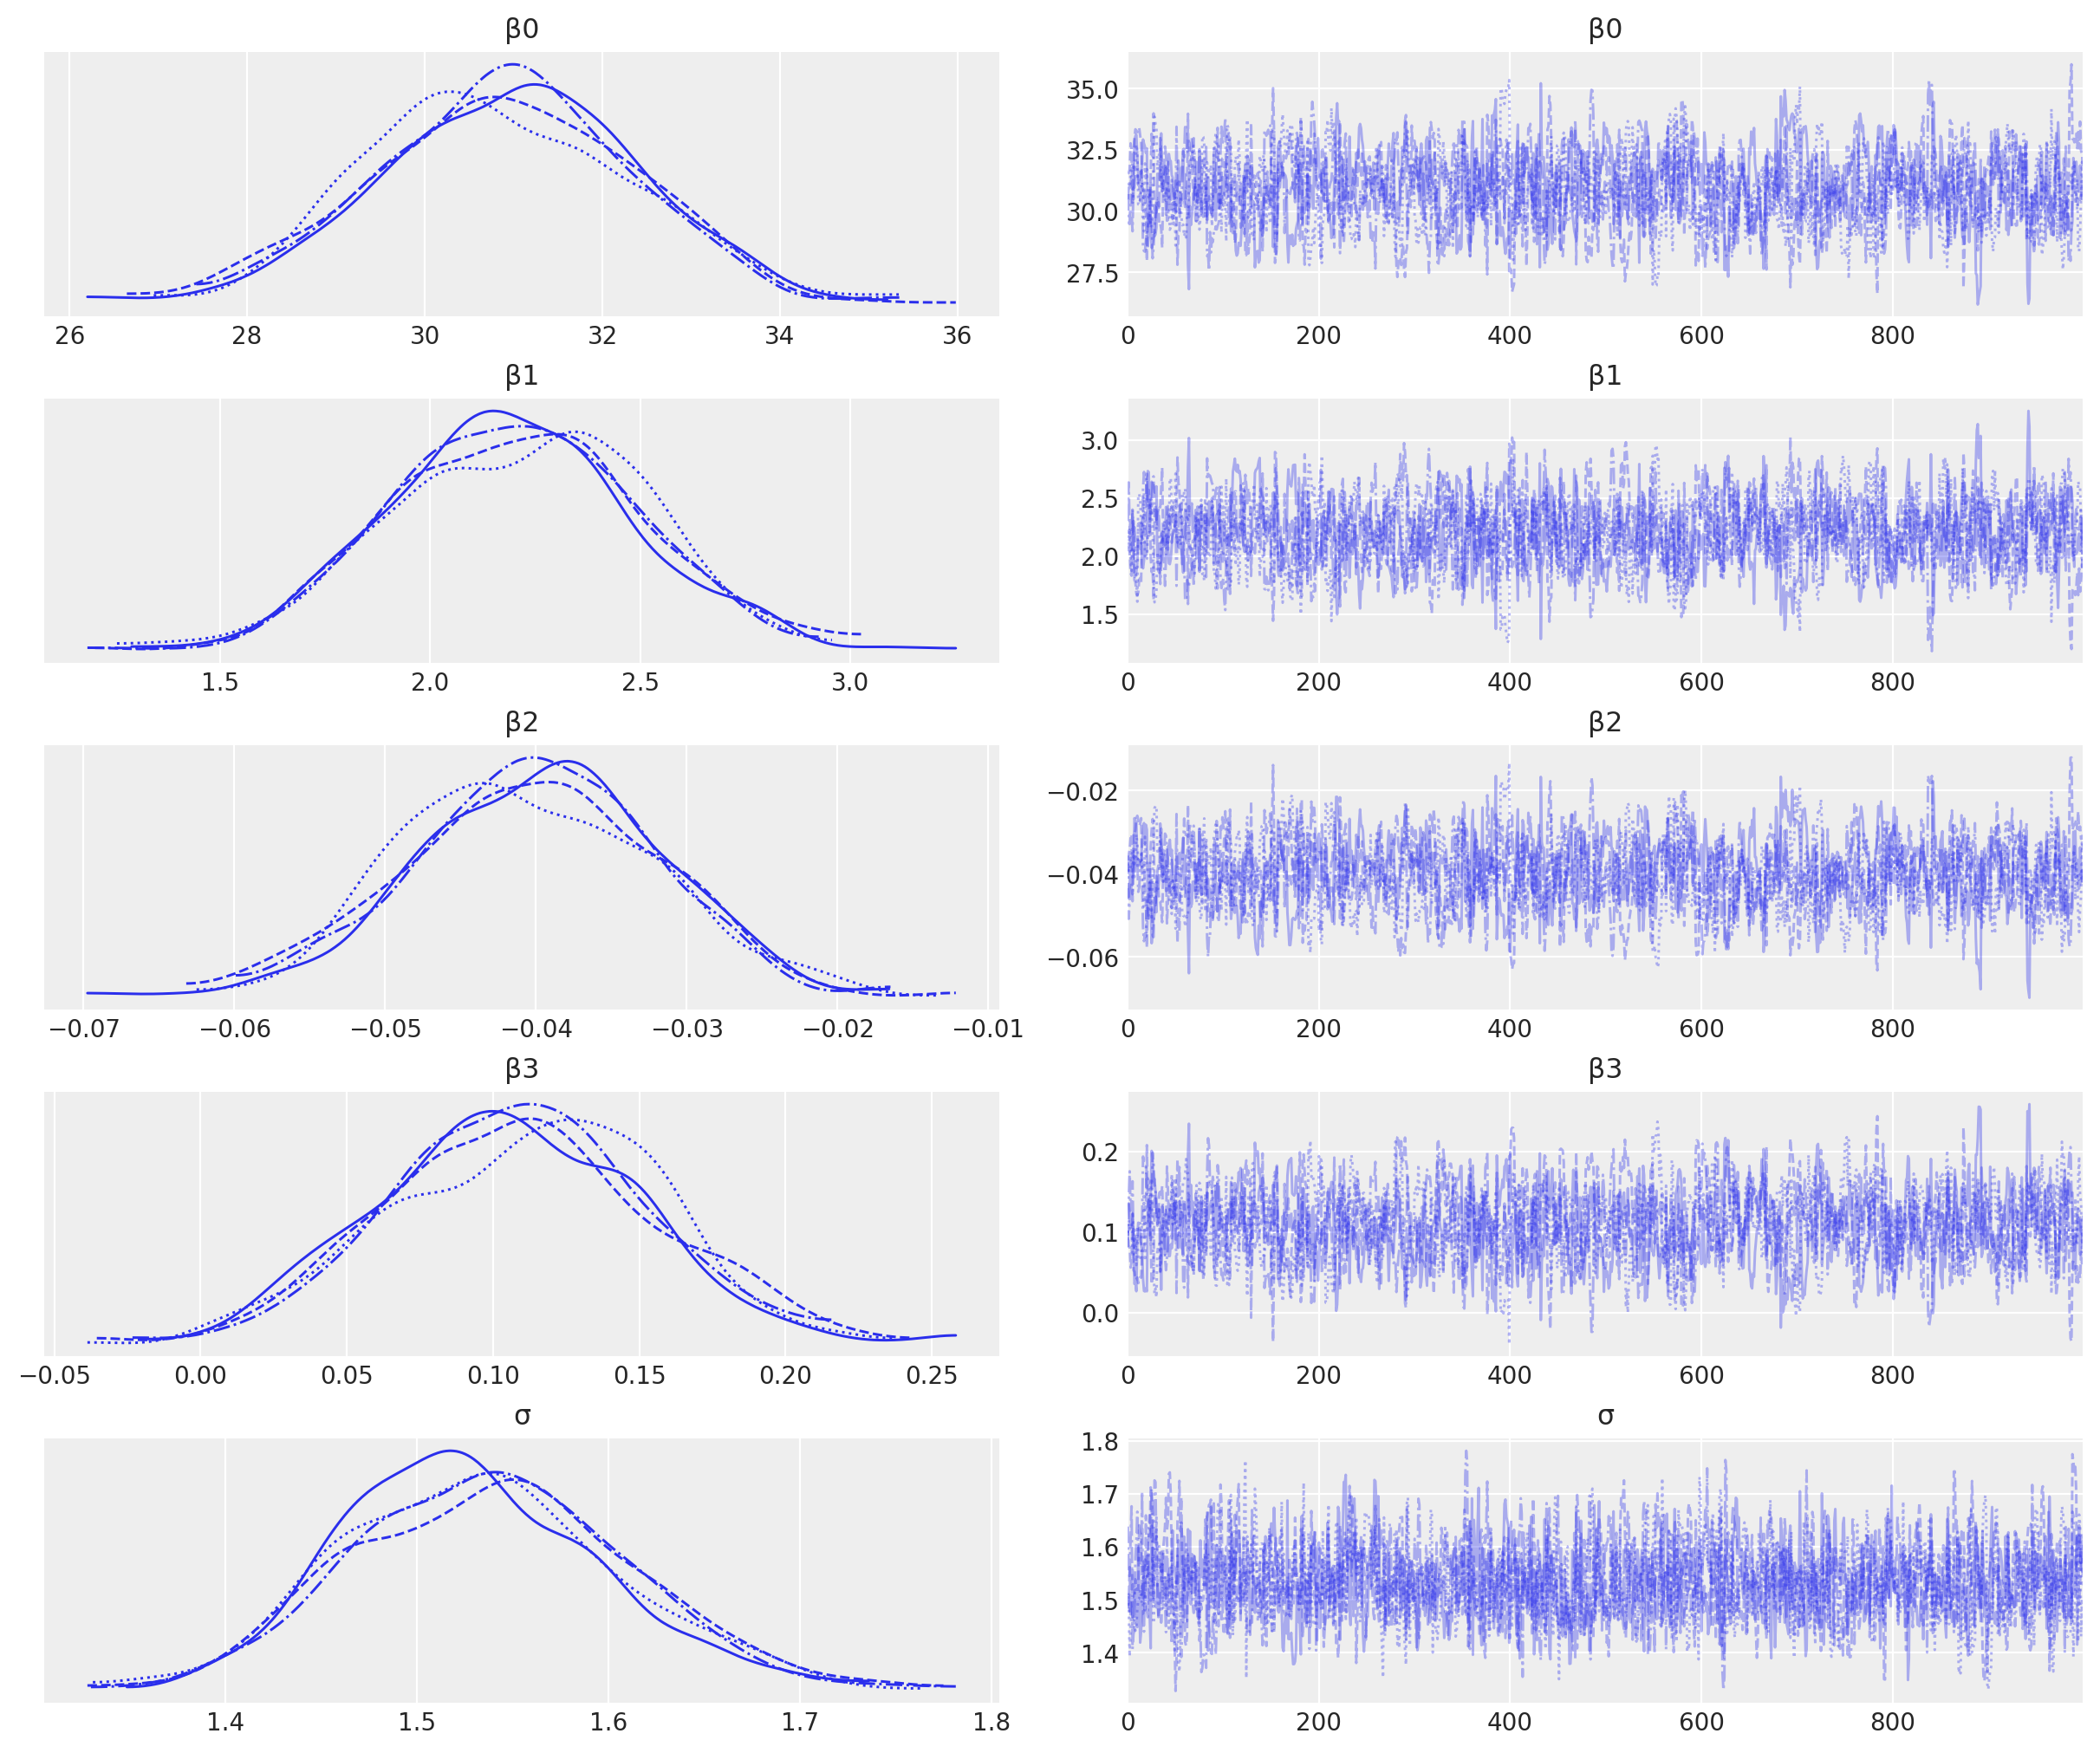

In [12]:
az.plot_trace(result);

We have good chain mixing and the posteriors for each chain look very similar, so no problems in that regard.

## Visualise the important parameters

First we will use a pair plot to look at joint posterior distributions. This might help us identify any estimation issues with the interaction term (see the discussion below about multicollinearity).

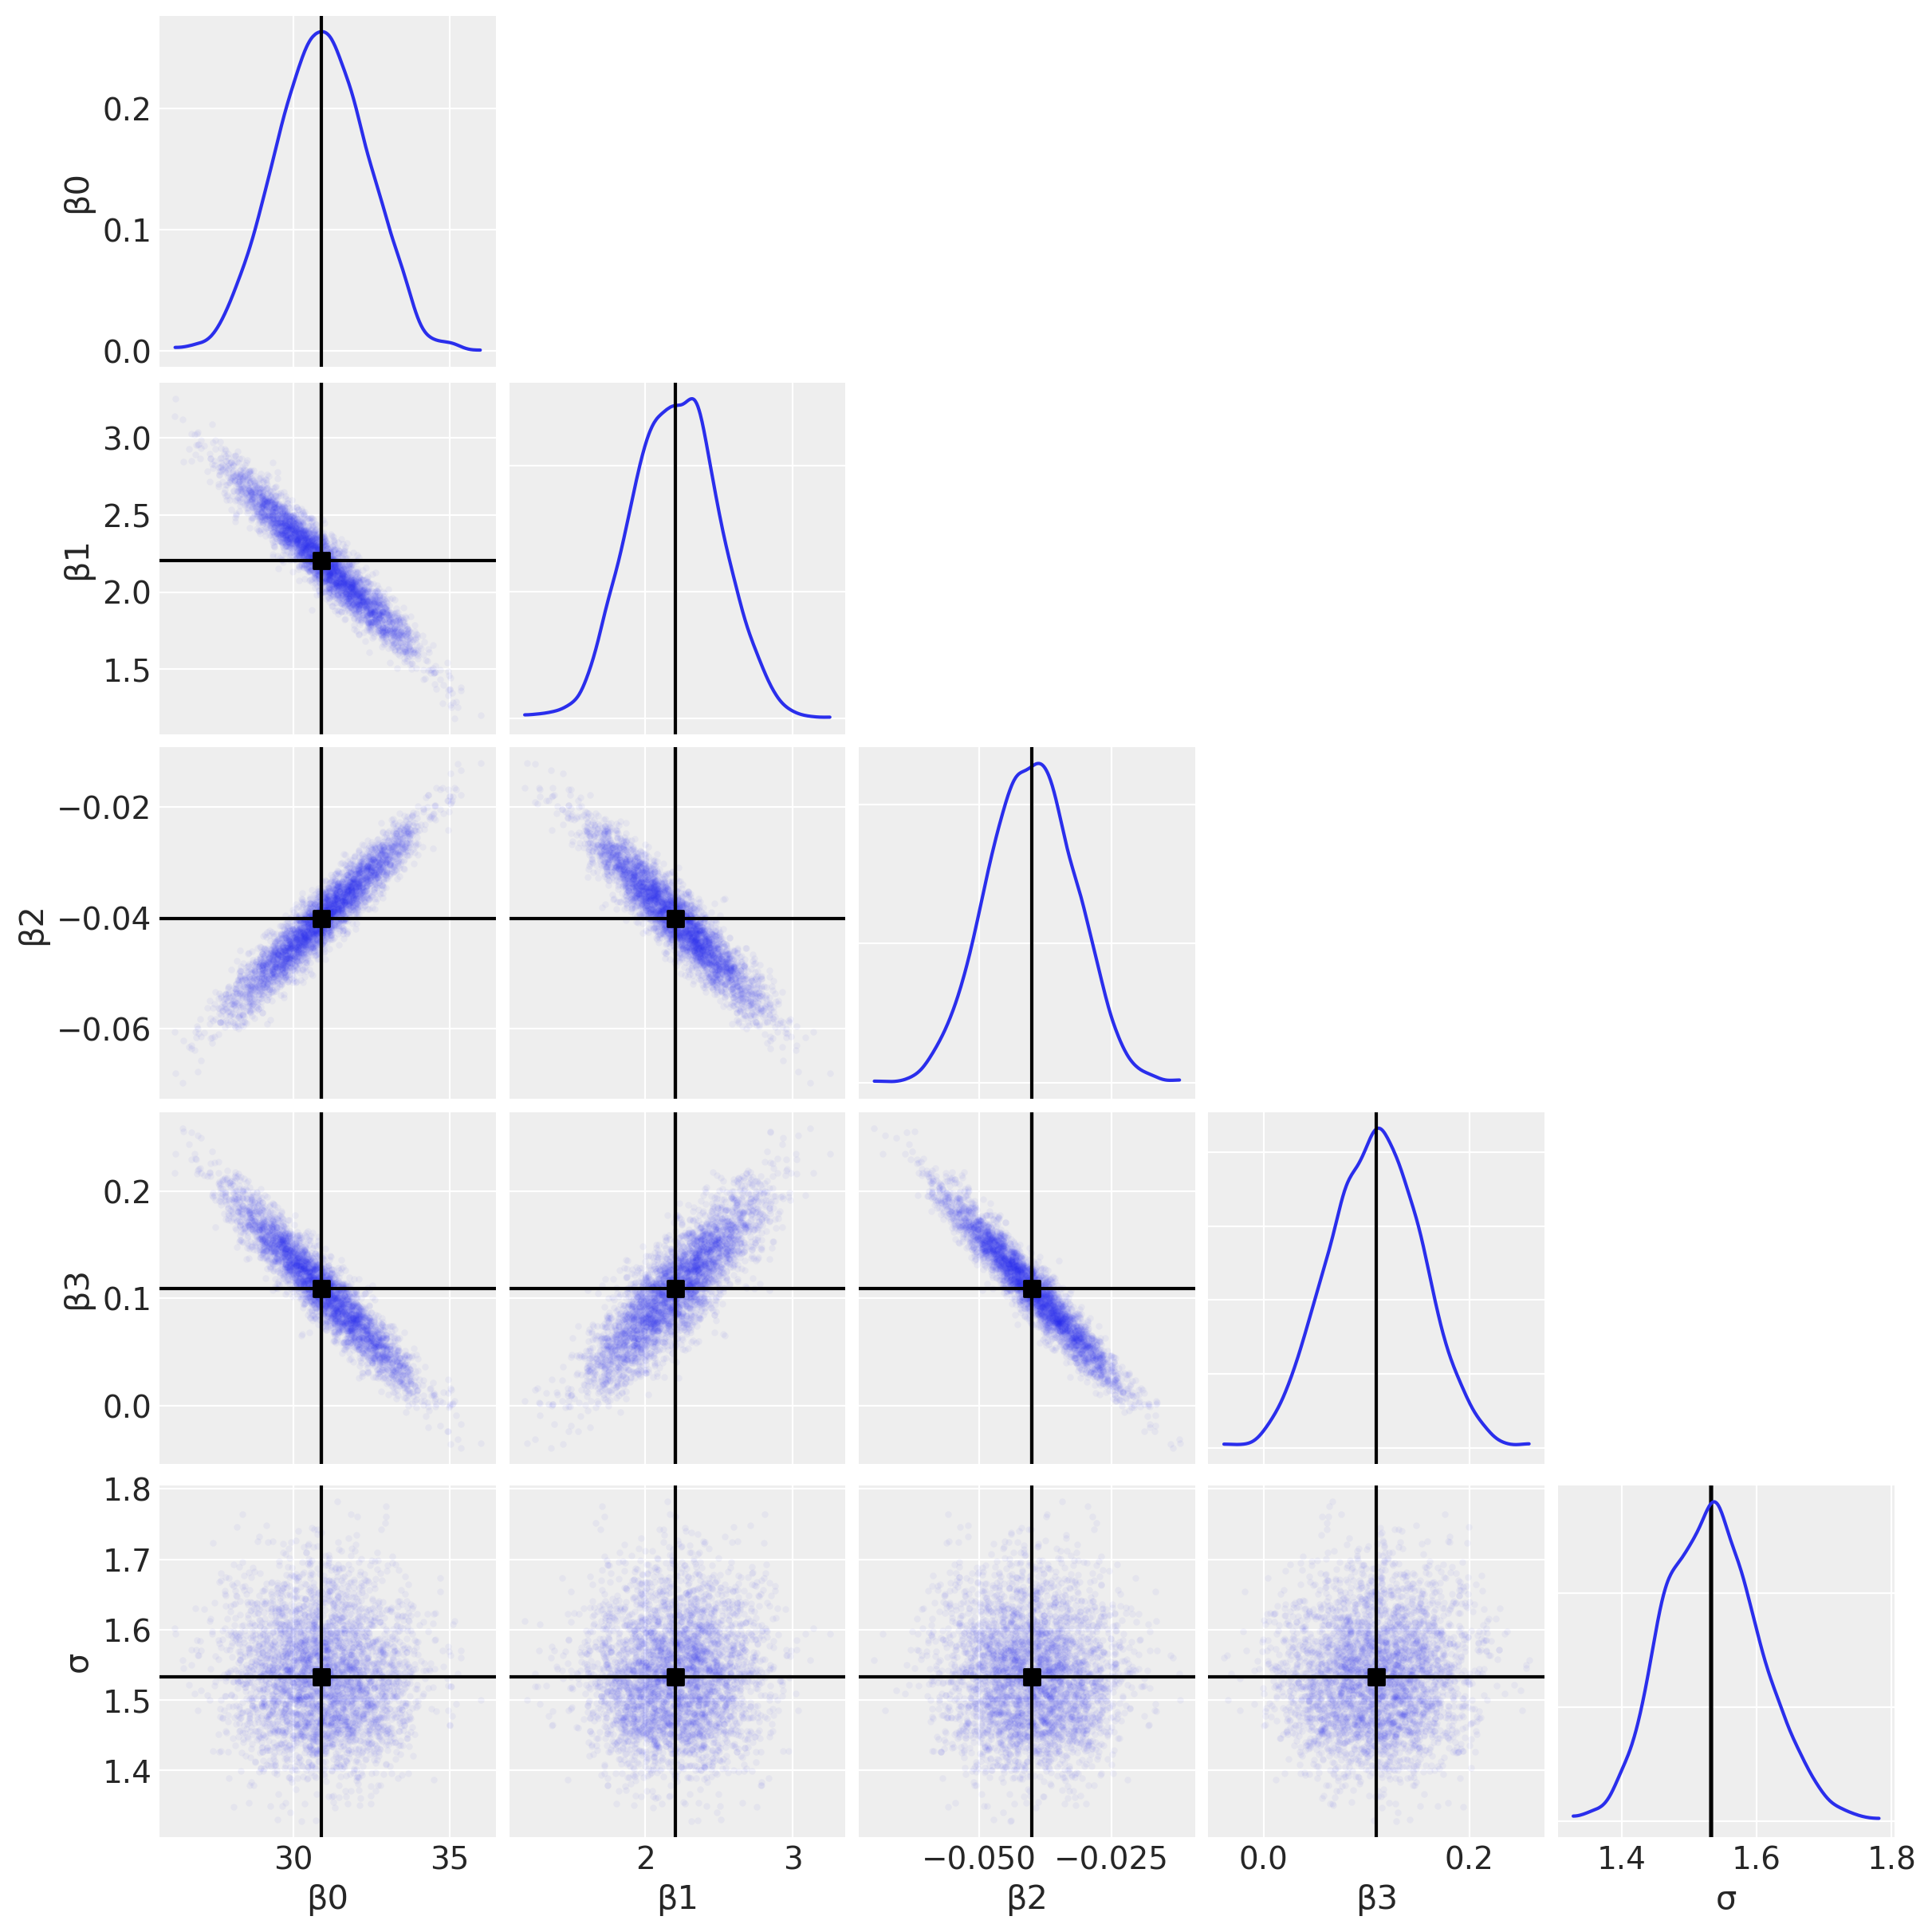

In [13]:
az.plot_pair(
    result,
    marginals=True,
    point_estimate="median",
    figsize=(12, 12),
    scatter_kwargs={"alpha": 0.05},
);

And just for the sake of completeness, we can plot the posterior distributions for each of the $\beta$ parameters and use this to arrive at research conclusions.

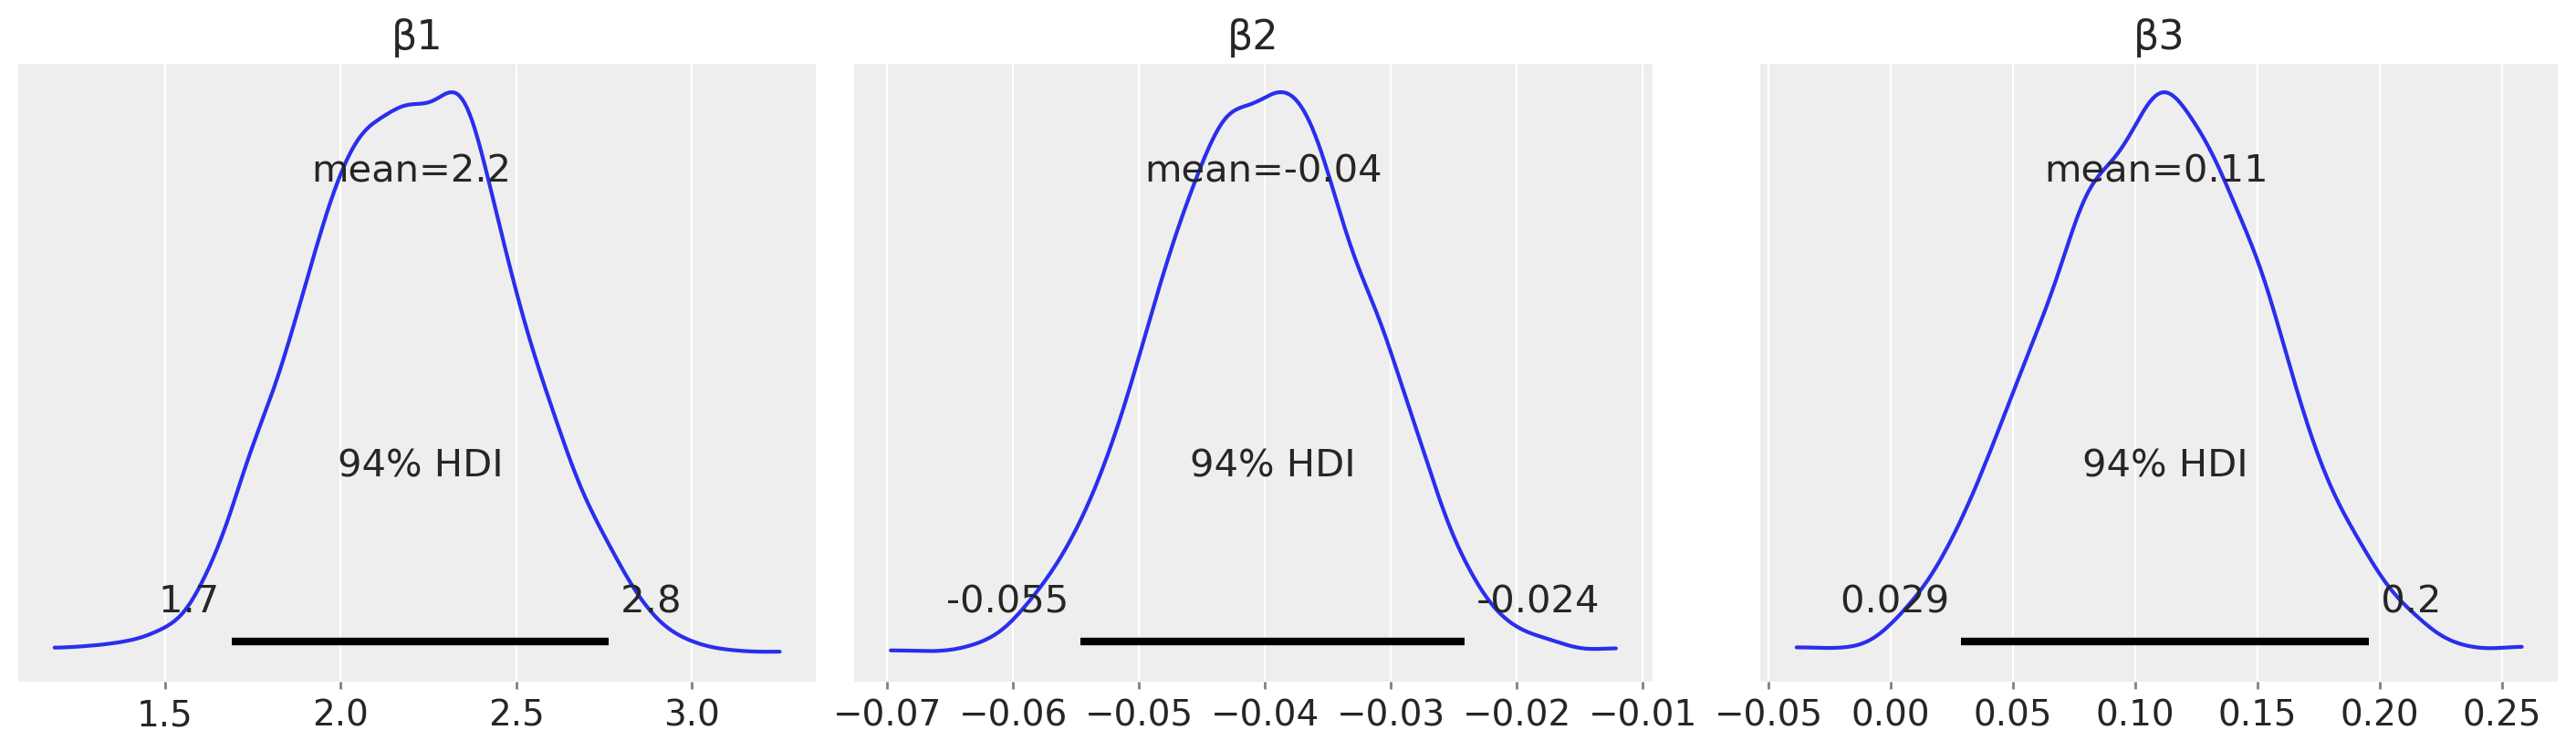

In [14]:
az.plot_posterior(result, var_names=["β1", "β2", "β3"], figsize=(14, 4));

For example, from an estimation (in contrast to a hypothesis testing) perspective, we could look at the posterior over $\beta_2$ and claim a credibly less than zero moderation effect.

## Posterior predictive checks
Define a set of quantiles of $m$ that we are interested in visualising.

In [15]:
m_quantiles = [0.025, 0.25, 0.5, 0.75, 0.975]

### Visualisation in data space
Here we will plot the data alongside model posterior predictive checks. This can be a useful visual method of comparing the model predictions against the data.

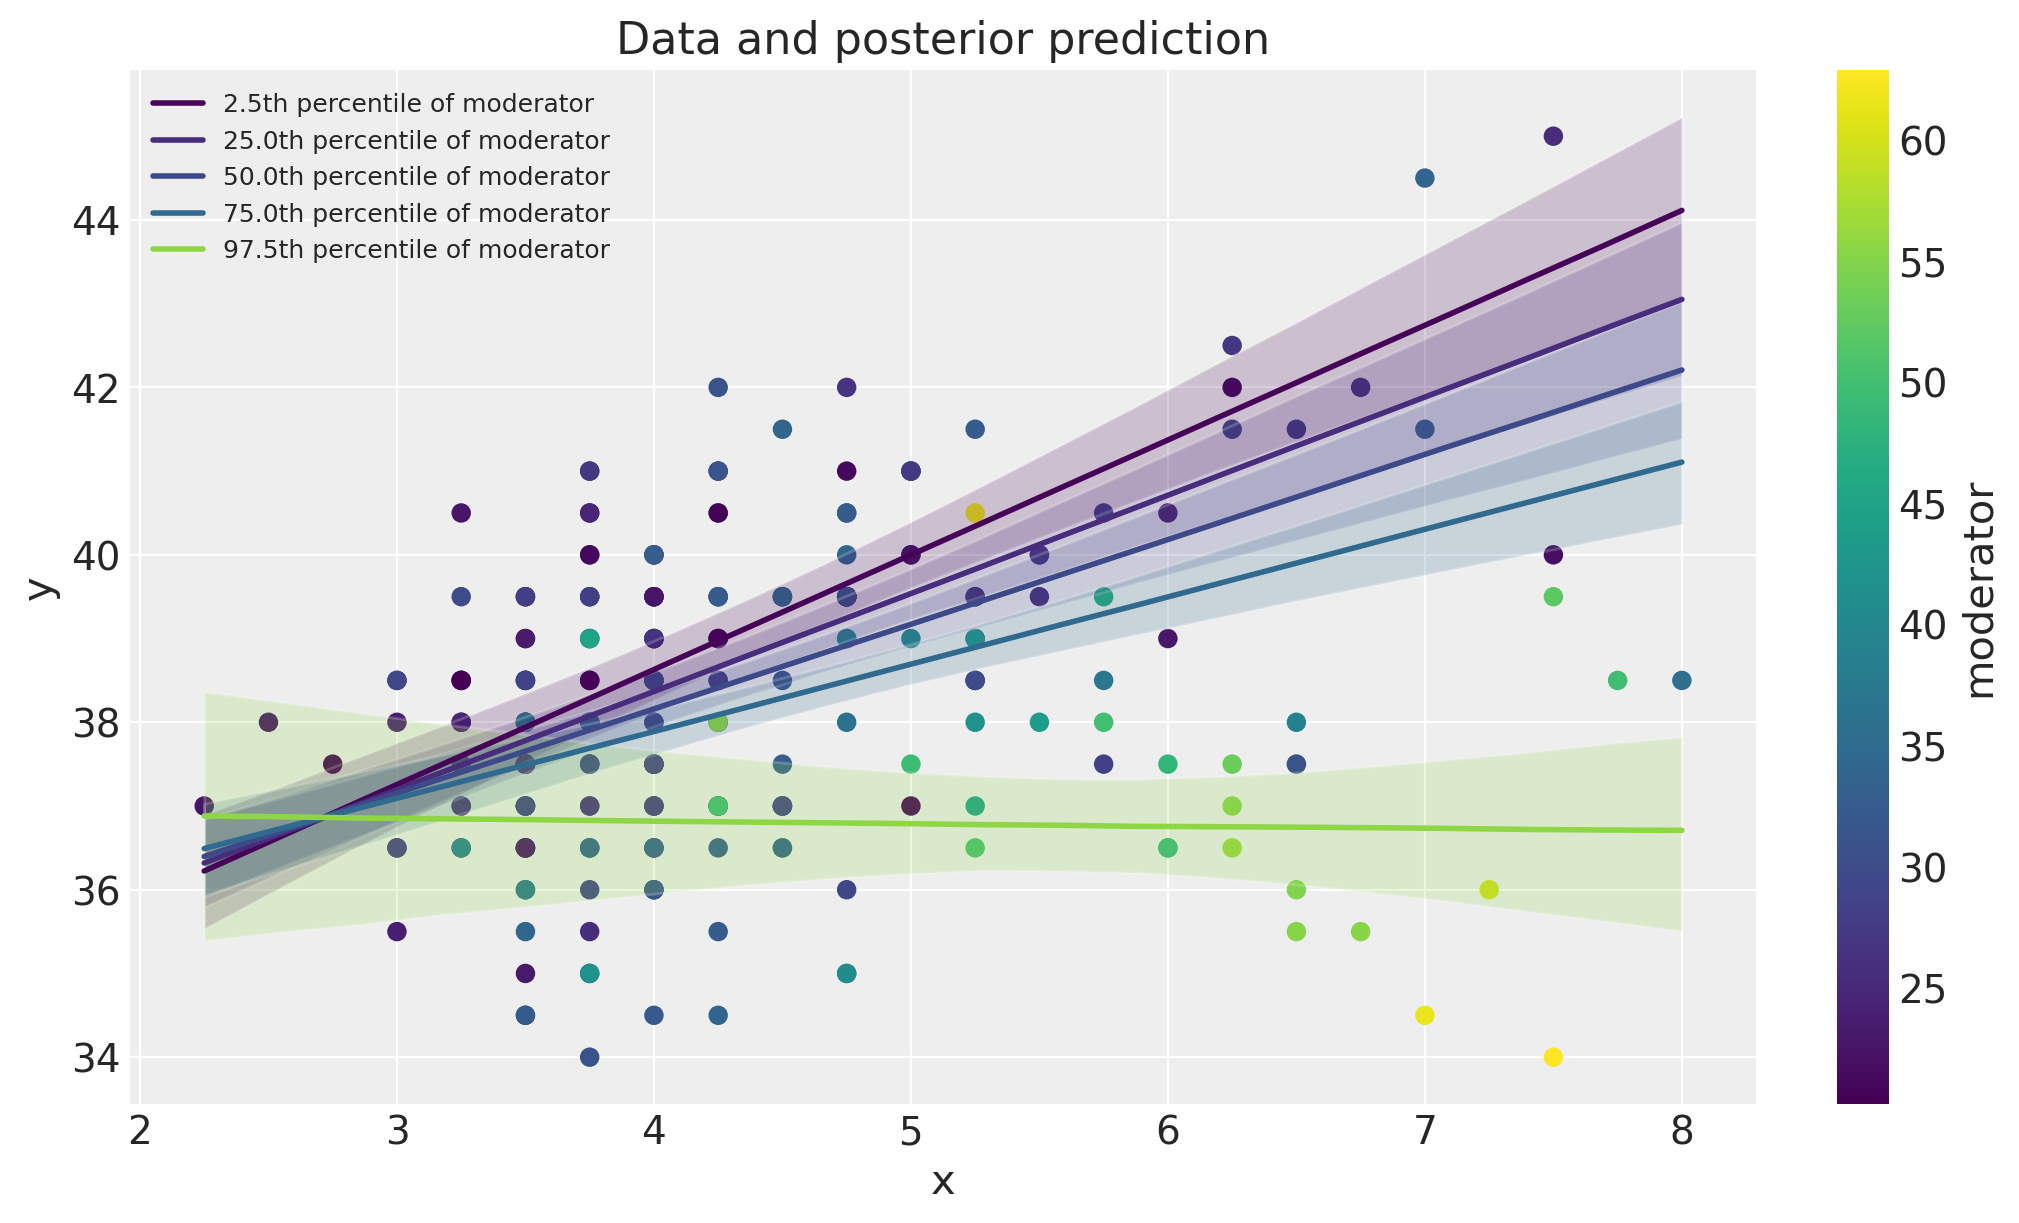

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))
ax = plot_data(x, m, y, ax=ax)
posterior_prediction_plot(result, x, m, m_quantiles, ax=ax)
ax.set_title("Data and posterior prediction");

### Spotlight graph
We can also visualise the moderation effect by plotting $\beta_1 + \beta_2 \cdot m$ as a function of the $m$. This was named a spotlight graph, see {cite:t}`spiller2013spotlights` and {cite:t}`mcclelland2017multicollinearity`.

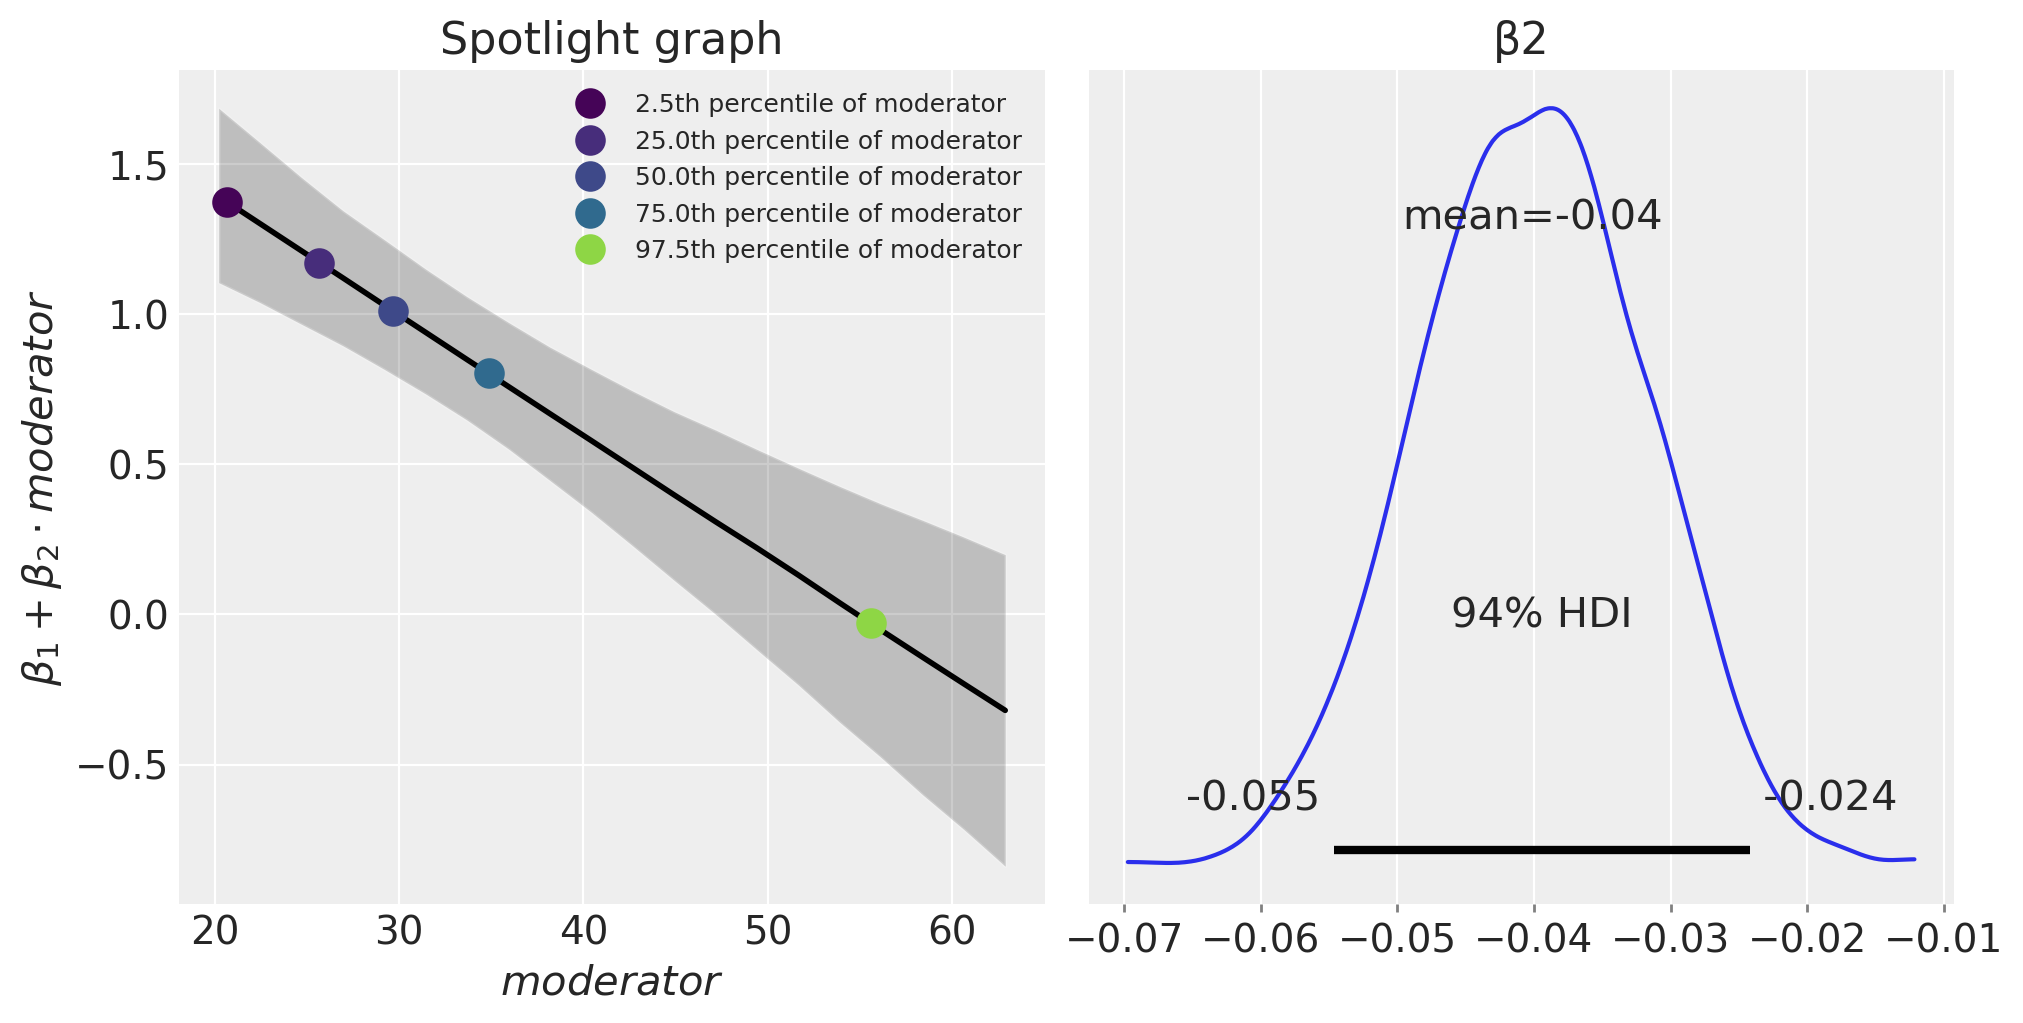

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_moderation_effect(result, m, m_quantiles, ax[0])
az.plot_posterior(result, var_names="β2", ax=ax[1]);

The expression $\beta_1 + \beta_2 \cdot \text{moderator}$ defines the rate of change of the outcome (muscle percentage) per unit of $x$ (training hours/week). We can see that as age (the moderator) increases, this effect of training hours/week on muscle percentage decreases.

## Related issues: mean centering and multicollinearity

Readers should be aware that there are issues around mean-centering and multicollinearity. The original [SPSS Moderation Regression Tutorial](https://www.spss-tutorials.com/spss-regression-with-moderation-interaction-effect/) did mean-centre the predictor variables $x$ and $m$. This will have a downstream effect upon the interaction term $x \cdot m$.

One effect of mean centering is to change the interpretation of the parameter estimates. In this notebook, we did not mean center the variables which will affect the parameter estimates and their interpretation. It is not that one is correct or incorrect, but one must be cognisant of how mean-centering (or not) affects the interpretation of parameter estimates. Readers are again directed to {cite:t}`hayes2017introduction` for a more in-depth consideration of mean-centering in moderation analyses.

Another issue, particularly relevant to moderation analysis is [multicollinearity](https://en.wikipedia.org/wiki/Multicollinearity), where one predictor variable is well-described as a linear combination of other predictors. This is clearly the case in moderation analysis as the interaction term $m \cdot x$ is by definition a linear combination of $x$ and $m$.

{cite:t}`iacobucci2016mean` explored the issues of mean-centering and multicollinearity and conclude:
 > When all is said and done, should a researcher mean center the X1 and X2 variables before computing a product term X1X2 to include in a moderated multiple regression? It depends. Mean centering is advisable when: (1) the predictor variables are measured on scales with arbitrary zeros and the researcher seeks to enhance the interpretation of the regression results vis-à-vis the variables’ means rather than the arbitrary zero points, or (2) the research questions involve testing the main effect terms in addition to the interaction term and the researcher seeks to obtain these statistical tests without the interference of the so-called nonessential multicollinearity. On the other hand, mean centering may be bypassed when: (1) the research question involves primarily the test of the interaction term, with no regard for the lower order main effect terms, or (2) the research question involves primarily the assessment of the overall fit of the model, the R2, with no interest in apportioning the explained variability across the predictors, main effects or interaction alike.
 
This was critiqued however by {cite:t}`mcclelland2017multicollinearity` who claimed that {cite:t}`iacobucci2016mean` made a number of errors, and that multicollinearity is a red herring:

> Multicollinearity is irrelevant to the search for moderator variables, contrary to the implications of Iacobucci, Schneider, Popovich, and Bakamitsos (Behavior Research Methods, 2016, this issue). Multicollinearity is like the red herring in a mystery novel that distracts the statistical detective from the pursuit of a true moderator relationship.

They state:

> Researchers using MMR [moderated multiple regression] need not compute any multicollinearity diagnostics nor worry about it at all. They need not use mean-centering or the orthogonal transformation or do anything else to avoid the purported problems of multicollinearity. The only purpose of those transformations is to facilitate understanding of MMR models.

Bearing in mind {cite:t}`mcclelland2017multicollinearity` took a frequentist hypothesis testing (not a Bayesian approach) their take-home points can be paraphrased as:
1. Fit the regression model, $y \sim \mathrm{Normal}(\beta_0 + \beta_1 \cdot x + \beta_2 \cdot x \cdot m + \beta_3 \cdot m, \sigma^2)$, with original (not mean-centred) data.
2. If the main interest is on the moderation effect, then focus upon $\beta_2$.
3. Transformations are useful if conditional relationships are to be highlighted.
4. "... researchers who wish to examine all possible conditional relationships or to help their readers who might want to consider other conditional relationships, should construct the [spotlight] graph..."

But readers are strongly encouraged to read {cite:t}`mcclelland2017multicollinearity` for more details, as well as the reply from {cite:t}`iacobucci2017mean`. Readers should also be aware that there are conflicting opinions and recommendations about mean centering etc in textbooks (see Further Reading below), some of which are published before 2017. None of these textbooks explicitly cite {cite:t}`mcclelland2017multicollinearity`, so it is unclear if the textbook authors are unaware of, agree with, or disagree with {cite:t}`mcclelland2017multicollinearity`.

## Further reading
- Further information about the 'moderation effect', or what {cite:t}`mcclelland2017multicollinearity` called a spotlight graphs, can be found in {cite:t}`bauer2005probing` and {cite:t}`spiller2013spotlights`. Although these papers take a frequentist (not Bayesian) perspective.
- {cite:t}`zhang2017moderation` compare maximum likelihood and Bayesian methods for moderation analysis with missing predictor variables.
- Multicollinearity, data centering, and linear models with interaction terms are also discussed in a number of prominent Bayesian text books {cite:p}`gelman2013bayesian, gelman2020regression,kruschke2014doing,mcelreath2018statistical`.

## Authors
- Authored by Benjamin T. Vincent in June 2021
- Updated by Benjamin T. Vincent in March 2022
- Updated by Benjamin T. Vincent in February 2023 to run on PyMC v5
- Updated to use `az.extract` by [Benjamin T. Vincent](https://github.com/drbenvincent) in February 2023 ([pymc-examples#522](https://github.com/pymc-devs/pymc-examples/pull/522))
- Updated by [Benjamin T. Vincent](https://github.com/drbenvincent) in May 2024 to incorporate causal concepts

## References
:::{bibliography}
:filter: docname in docnames
:::

## Watermark

In [18]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor,aeppl,xarray

Last updated: Fri May 17 2024

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.24.0

pytensor: 2.20.0
aeppl   : not installed
xarray  : 2024.5.0

daft      : 0.1.2
matplotlib: 3.8.4
pandas    : 2.2.2
xarray    : 2024.5.0
pymc      : 5.15.0
numpy     : 1.26.4
arviz     : 0.18.0

Watermark: 2.4.3



:::{include} ../page_footer.md
:::